In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')
import matplotlib 
%matplotlib inline
from glmsingle.glmsingle import GLM_single

In [2]:
# get path to the directory to which GLMsingle was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

# create directory for saving outputs from example 1
outputdir = join(homedir,'examples','example1outputs')

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example1 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/mnt/cup/labs/norman/pscotti/rtmindeye/code/analysis/examples/data

directory to save example1 outputs:
	/mnt/cup/labs/norman/pscotti/rtmindeye/code/analysis/examples/example1outputs



In [3]:
datafn = join(datadir,'nsdcoreexampledataset.mat')

# to save time, we'll skip the download if the example dataset already exists on disk
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/k89b2/download'
    
    # download the .mat file to the specified directory
    urllib.request.urlretrieve(dataurl, datafn)
    
# load struct containing example dataset
X = sio.loadmat(datafn)

/mnt/cup/labs/norman/pscotti/rtmindeye/code/analysis/examples/data/nsdcoreexampledataset.mat


In [4]:
# variables that will contain bold time-series and design matrices from each run
data = []
design = []

# iterate through each run of data
for r in range(len(X['data'][0])):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

# get visual ROI mask identifying occipital cortex
roi = X['ROI']

In [14]:
X['data'][0,r].shape

(145, 186, 1, 300)

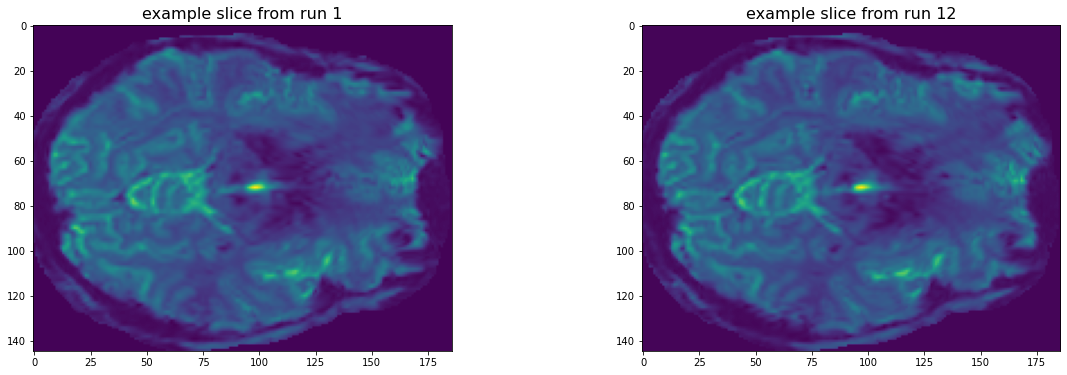

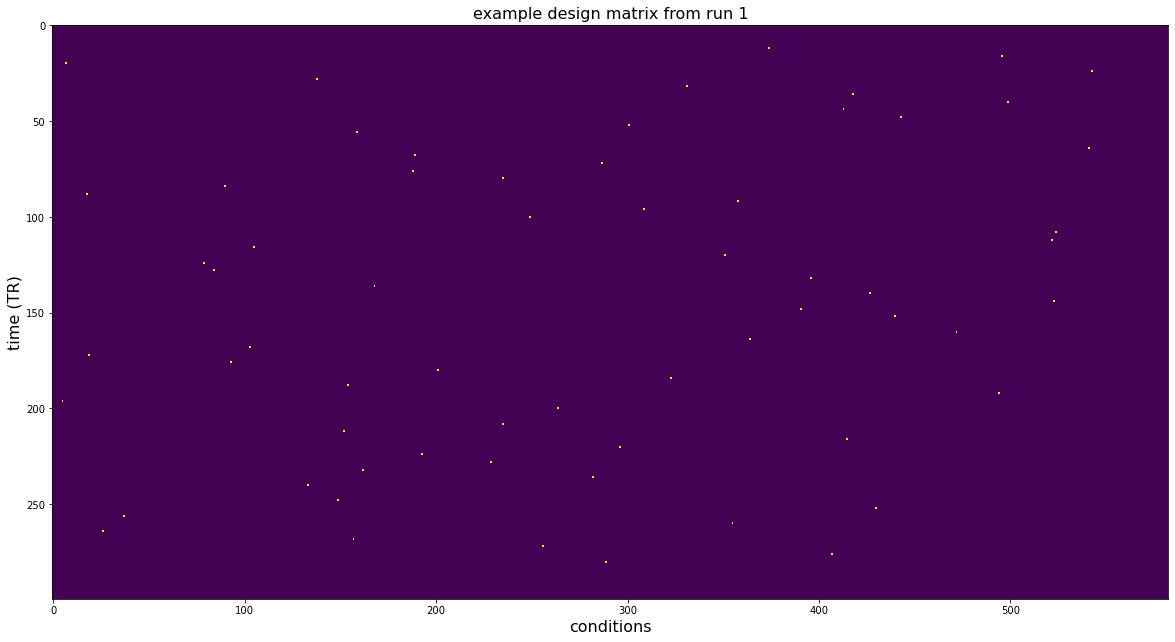

In [5]:
# plot example slice from run 1
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,0,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[11][:,:,0,0])
plt.title('example slice from run 12',fontsize=16)

# plot example design matrix from run 1
plt.figure(figsize=(20,20))
plt.imshow(design[0],interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

In [6]:
# print some relevant metadata
print(f'There are {len(data)} runs in total\n')
print(f'N = {data[0].shape[3]} TRs per run\n')
print(f'The dimensions of the data for each run are: {data[0].shape}\n')
print(f'The stimulus duration is {stimdur} seconds\n')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only in this example)\n')
print(f'Numeric precision of data is: {type(data[0][0,0,0,0])}\n')
print(f'There are {np.sum(roi)} voxels in the included visual ROI')

There are 12 runs in total

N = 300 TRs per run

The dimensions of the data for each run are: (145, 186, 1, 300)

The stimulus duration is 3 seconds

XYZ dimensionality is: (145, 186, 1) (one slice only in this example)

Numeric precision of data is: <class 'numpy.float32'>

There are 2653 voxels in the included visual ROI


In [7]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1718128312.6138003,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [10]:
design[0].shape

(300, 583)

In [11]:
data[0].shape

(145, 186, 1, 300)

In [ ]:
# this example saves output files to the folder  "example1outputs/GLMsingle"
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

if not exists(outputdir_glmsingle):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)